In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate
from prepare_dataset import *
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, beta=0.9):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        """
        Forward pass through the SNN using both spikes and membrane potentials.
        
        Parameters:
        - x: Input tensor of shape (batch_size, input_size, num_timesteps)
        
        Returns:
        - spk_rec: Spikes recorded over timesteps.
        - mem_rec: Membrane potentials recorded over timesteps.
        """
        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record spikes and membrane potentials
        spk_rec = []
        mem_rec = []

        for step in range(x.size(2)):  # Iterate over time steps
            cur_input = x[:, :, step]  # Input at the current timestep

            # First layer
            mem1, spk1 = self.lif1(self.fc1(cur_input), mem1)

            # Second layer
            mem2, spk2 = self.lif2(self.fc2(spk1), mem2)

            # Record spikes and membrane potentials
            spk_rec.append(spk2)
            mem_rec.append(mem2)

        return torch.stack(spk_rec, dim=2), torch.stack(mem_rec, dim=2)


In [8]:
"""
All of the functions
"""

def compute_class_weights(train_loader):
    class_counts = np.zeros(4)  # Assuming 4 classes: Up, Down, Right, Left

    # Count occurrences of each class in the training dataset
    for _, labels in train_loader:
        for label in labels.cpu().numpy():
            class_counts[label] += 1

    # Inverse frequency
    class_weights = 1. / class_counts
    class_weights = class_weights / np.sum(class_weights)  # Normalize to sum to 1

    # Convert to tensor
    return torch.tensor(class_weights, dtype=torch.float32)

def plot_label_distribution(train_loader, val_loader, test_loader):
    """
    Plot label distribution for the train, validation, and test DataLoaders.

    Parameters:
    - train_loader: DataLoader for the training set.
    - val_loader: DataLoader for the validation set.
    - test_loader: DataLoader for the test set.
    """
    # Function to collect label frequencies
    def collect_labels(loader):
        labels = []
        for _, label_batch in loader:
            labels.extend(label_batch.cpu().numpy())
        return np.array(labels)

    # Collect labels from each dataset
    train_labels = collect_labels(train_loader)
    val_labels = collect_labels(val_loader)
    test_labels = collect_labels(test_loader)

    # Plot label distribution
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plotting for each dataset
    ax[0].hist(train_labels, bins=np.arange(5)-0.5, edgecolor="black", alpha=0.7)
    ax[0].set_title("Training Set Label Distribution")
    ax[0].set_xlabel("Class")
    ax[0].set_ylabel("Frequency")
    ax[0].set_xticks([0, 1, 2, 3])
    ax[0].set_xticklabels(["Up", "Down", "Right", "Left"])

    ax[1].hist(val_labels, bins=np.arange(5)-0.5, edgecolor="black", alpha=0.7)
    ax[1].set_title("Validation Set Label Distribution")
    ax[1].set_xlabel("Class")
    ax[1].set_ylabel("Frequency")
    ax[1].set_xticks([0, 1, 2, 3])
    ax[1].set_xticklabels(["Up", "Down", "Right", "Left"])

    ax[2].hist(test_labels, bins=np.arange(5)-0.5, edgecolor="black", alpha=0.7)
    ax[2].set_title("Test Set Label Distribution")
    ax[2].set_xlabel("Class")
    ax[2].set_ylabel("Frequency")
    ax[2].set_xticks([0, 1, 2, 3])
    ax[2].set_xticklabels(["Up", "Down", "Right", "Left"])

    plt.tight_layout()
    plt.show()


def create_data_loaders(dataset, train_frac=0.7, val_frac=0.2, test_frac=0.1, batch_size=16, shuffle=True):
    """
    Splits the dataset into training, validation, and test sets, and creates DataLoaders.
    
    Parameters:
    - dataset: The full dataset (TensorDataset).
    - train_frac: Fraction of the dataset to use for training.
    - val_frac: Fraction of the dataset to use for validation.
    - test_frac: Fraction of the dataset to use for testing.
    - batch_size: The batch size for the DataLoaders.
    - shuffle: Whether to shuffle the dataset.
    
    Returns:
    - train_loader: DataLoader for the training set.
    - val_loader: DataLoader for the validation set.
    - test_loader: DataLoader for the test set.
    """

    # Get dataset size
    total_size = len(dataset)
    
    # Calculate sizes for each subset
    train_size = int(total_size * train_frac)
    val_size = int(total_size * val_frac)
    test_size = total_size - train_size - val_size  # Remaining size for test set
    
    # Split the dataset into train, val, and test subsets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

def train_snn(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):
    """
    Train and validate the SNN model, returning training and validation losses.
    
    Parameters:
    - model: The SNN model to train.
    - train_loader: DataLoader for the training set.
    - val_loader: DataLoader for the validation set.
    - criterion: The loss function.
    - optimizer: The optimizer to use.
    - num_epochs: The number of epochs to train.
    - device: The device ('cuda' or 'cpu') where the model is running.
    
    Returns:
    - train_losses: List of training losses for each epoch.
    - val_losses: List of validation losses for each epoch.
    """
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for batch_idx, (spikes, labels) in enumerate(train_loader):
            spikes, labels = spikes.to(device), labels.to(device)
            optimizer.zero_grad()

            spk_rec, mem_rec = model(spikes)
            num_timesteps = spk_rec.size(2)

            # Compute loss using membrane potential across all timesteps
            total_loss = torch.zeros(1, device=device)
            for step in range(num_timesteps):
                total_loss += criterion(mem_rec[:, :, step].squeeze(1), labels)  # Use membrane potential for loss

            total_loss /= num_timesteps  # Normalize by timesteps
            total_loss.backward()
            optimizer.step()

            total_train_loss += total_loss.item()

            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Train Loss: {total_loss.item():.4f}", end='\r')

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for spikes, labels in val_loader:
                spikes, labels = spikes.to(device), labels.to(device)

                spk_rec, mem_rec = model(spikes)
                num_timesteps = spk_rec.size(2)

                # Compute validation loss using membrane potential across all timesteps
                total_loss = torch.zeros(1, device=device)
                for step in range(num_timesteps):
                    total_loss += criterion(mem_rec[:, :, step].squeeze(1), labels)  # Use membrane potential for loss

                total_loss /= num_timesteps
                total_val_loss += total_loss.item()

                # Calculate accuracy based on spike count
                spike_count = spk_rec.sum(dim=2)  # Sum spikes across all timesteps
                _, predicted = torch.max(spike_count, 1)  # Use spike count for accuracy
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct / total

        print(f"\nEpoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses


def test_snn(model, test_loader, device):
    """
    Test the SNN model and return performance metrics including accuracy, precision, recall, F1 score, and confusion matrix.
    
    Parameters:
    - model: The trained SNN model.
    - test_loader: DataLoader for the test set.
    - device: The device ('cuda' or 'cpu') where the model is running.
    
    Returns:
    - accuracy: The accuracy of the model on the test set.
    - precision: Precision score.
    - recall: Recall score.
    - f1_score: F1 score.
    - confusion_matrix: The confusion matrix.
    """
    model.to(device)
    model.eval()  # Set model to evaluation mode

    all_labels = []
    all_preds = []
    total_correct = 0
    total = 0

    with torch.no_grad():
        for spikes, labels in test_loader:
            spikes, labels = spikes.to(device), labels.to(device)
            spk_rec, mem_rec = model(spikes)
            outputs = mem_rec[:, :, -1]  # Use last timestep for classification
            _, predicted = torch.max(outputs, 1)

            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * total_correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Classification report with zero_division to handle undefined metrics
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Up", "Down", "Right", "Left"], zero_division=1))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Up", "Down", "Right", "Left"], yticklabels=["Up", "Down", "Right", "Left"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return accuracy, cm

Batches in train, val, and test loader: 98, 28, 14
Samples in train, val, and test loader: 1568, 448, 224


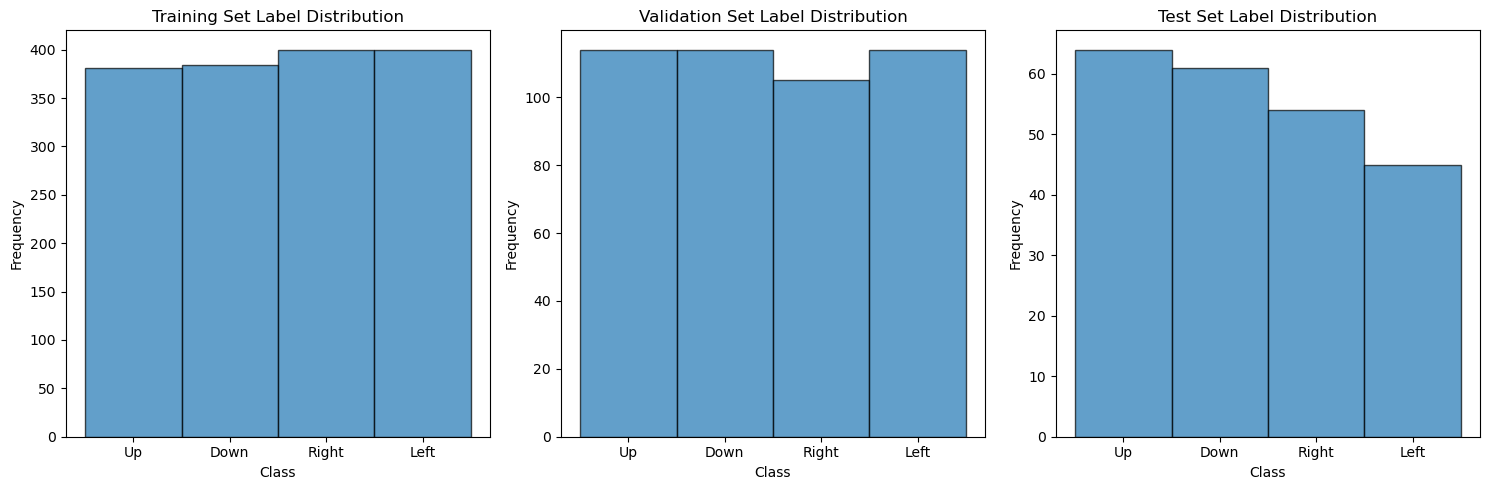

In [ ]:
root_dir = "inner-speech-recognition"
root_dir = "C:/Users/lovak/OneDrive - Luleå University of Technology/År 4/D7064E/proj/inner-speech-recognition"
n_s = 1
model_type = "SNN"
fs = 256
Tstart = 1.5
Tend = 3.5
encoding = "poisson"

X, Y = create_dataset_for_all_subjects(root_dir, model_type, fs, Tstart, Tend, encoding)
# X shape (trials, channels, time)
X, Y = create_dataset(root_dir, model_type, fs, 
                   Tstart, Tend, encoding)

X = torch.tensor(X, dtype=torch.float32)  # Convert to tensor, adjust dtype if needed
Y = torch.tensor(Y, dtype=torch.long)    # Ensure labels are integers




train_data = torch.utils.data.TensorDataset(X, Y)
#train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

train_loader, val_loader, test_loader = create_data_loaders(train_data, train_frac=0.7, val_frac=0.2, test_frac=0.1, batch_size=16, shuffle=True)


print(f'Batches in train, val, and test loader: {len(train_loader)}, {len(val_loader)}, {len(test_loader)}')
print(f'Samples in train, val, and test loader: {len(train_loader) * 16}, {len(val_loader)*16 }, {len(test_loader)*16}')
plot_label_distribution(train_loader, val_loader, test_loader)

In [13]:
input_size = X.shape[1]  # Number of channels
hidden_size = 64  # Hidden layer size
num_classes = len(torch.unique(Y))  # Number of classes


snn_model = SNN(input_size, hidden_size, num_classes)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(snn_model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10

train_losses, val_losses = train_snn(snn_model, train_loader, val_loader, criterion, optimizer, num_epochs, device)



In [ ]:

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_snn(snn_model, test_loader, device)